<img src="https://www.th-koeln.de/img/logo.svg" style="float:right;" width="200">

# 13th exercise: <font color="#C70039">Deep Learning: Data Windowing</font>
* Course: <a href="https://www.gernotheisenberg.de/time_series_forecasting.html">Time Series Forecasting (TSF)</a>
* Lecturer: <a href="https://www.gernotheisenberg.de/uebermich.html">Gernot Heisenberg</a>
* Date:   24.03.2025

<img src="./images/datawindowing.jpg" style="float: center;" width="450">

---------------------------------
**GENERAL NOTE 1**: 
Please make sure you are reading the entire notebook, since it contains a lot of information on your tasks (e.g. regarding the set of certain paramaters or a specific computational trick), and the written mark downs as well as comments contain a lot of information on how things work together as a whole. 

**GENERAL NOTE 2**: 
* Please, when commenting source code, just use English language only. 
* When describing an observation please use English language, too
* This applies to all exercises throughout this course.  

---------------------

### <font color="ce33ff">DESCRIPTION OF THE NOTEBOOK CONTENT</font>:
This notebook allows you for learning about how to implement a DataWindow class which supports the forecasting activities using Deep Learning approaches and makes them extremely simple. 

-------------------------------------------------------------------------------------------------------------

### <font color="FFC300">TASKS</font>:
The tasks that you need to work on within this notebook are always indicated below as bullet points. 
If a task is more challenging and consists of several steps, this is indicated as well. 
Make sure you have worked down the task list and commented your doings. 
This should be done by using markdown.<br> 
<font color=red>Make sure you don't forget to specify your name and your matriculation number in the notebook.</font>

**YOUR TASKS in this exercise are as follows**:
1. import the notebook to Google Colab or use your local machine.
2. make sure you specified you name and your matriculation number in the header below my name and date. 
    * set the date too and remove mine.
3. read the entire notebook carefully 
    * add comments whereever you feel it necessary for better understanding
    * run the notebook for the first time.
    * understand the output
4. Data windowing with the pollution data set
    * In the previous exercise, we prepared the air pollution dataset for deep learning modeling. Now we are going to use the training set, validation set and test set to build baseline models and evaluate them.
    * For each type of model, follow the steps below. Remember that the target for the singlestep and multi-step model is the concentration of NO2 and the targets for the multi-output model are the concentration of NO2 and temperature. 
    * For the single-step model:
        * Build a baseline model that predicts the last known value.
        * Plot it.
        * Evaluate its performance using the mean absolute error (MAE) and store it for comparison in a dictionary.
    * For the multi-step model:
        * Build a baseline that predicts the last known value over a horizon of 24 hours.
        * Build a baseline model that repeats the last 24 hours.
        * Plot the predictions of both models.
        * Evaluate both models using the MAE and store their performance.
    * For the multi-output model:
        * Build a baseline model that predicts the last known value.
        * Plot it.
        * Evaluate its performance using the MAE and store it for comparison in a dictionary.
-----------------------------------------------------------------------------------

In [1]:
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

import warnings
warnings.filterwarnings('ignore')

print('tf.keras.__version__=',tf.keras.__version__)
print("tf.__version__=", tf.__version__)

tf.keras.__version__= 2.10.0
tf.__version__= 2.10.0


In [2]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

tf.random.set_seed(42)
np.random.seed(42)

# 13.1 Loading the data 

In [3]:
train_df = pd.read_csv('./data/DL/train.csv', index_col=0)
val_df   = pd.read_csv('./data/DL/val.csv', index_col=0)
test_df  = pd.read_csv('./data/DL/test.csv', index_col=0)

print(train_df.shape, val_df.shape, test_df.shape)

(12285, 5) (3510, 5) (1756, 5)


## 13.1 Creating windows of data
### 13.1.1 Split and visualize the data set into chunks of 24 data values

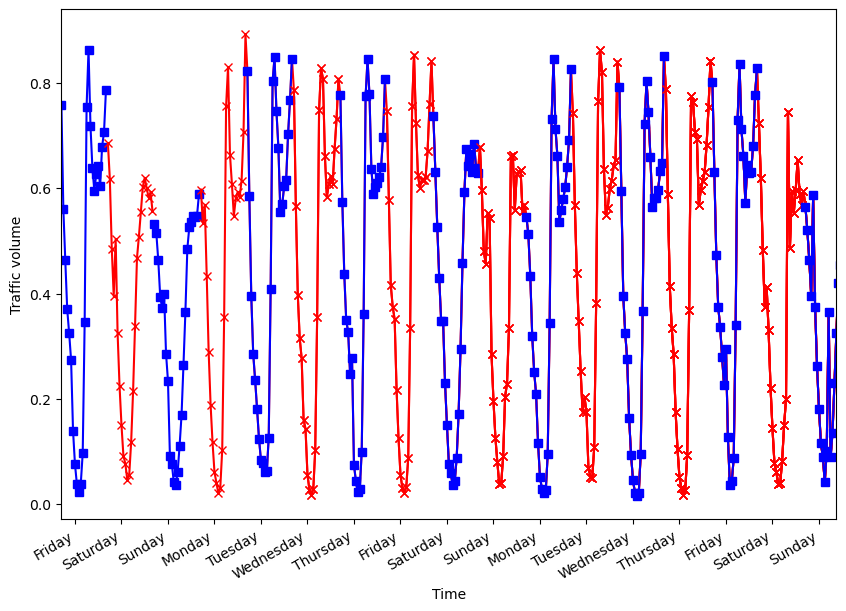

In [4]:
fig, ax = plt.subplots()

for n in range(0,17,2):
    start = 24*n
    stop = 24*(n+1)
    ax.plot(train_df.traffic_volume[start:stop], marker='s', color='blue', label='input')
    ax.plot(train_df.traffic_volume[stop:2*stop], marker='x', color='red', label='label')
ax.set_xlabel('Time')
ax.set_ylabel('Traffic volume')

plt.xticks(np.arange(7, 400, 24), ['Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.xlim(0, 400)

fig.autofmt_xdate()

### 13.1.2 Implementing the `DataWindow` class 

In [5]:
class DataWindow():
    '''the initialization function of the class assigns the variables and manages the indices of the inputs and the labels.'''
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df, 
                 label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        # Name of the column that we wish to predict
        self.label_columns = label_columns
        if label_columns is not None:
            # Create a dict with the name and index of the label column.
            # This will be used for visulization later.
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        # Create a dict with the name and index of each column. 
        # This will be used to separate the features from the target variable.
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        self.total_window_size = input_width + shift
        
        ''' The slice function returns a slice object that specifies how
            to slice a sequence. In this case, it says that the input slice 
            starts at 0 and ends when we reach the input_width.'''
        self.input_slice = slice(0, input_width)
        # Assign indices to the inputs. These are useful for visualization.
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        # Get the index at which the label starts. In this case, it is the total window size minus the width of the label.
        self.label_start = self.total_window_size - self.label_width
        # The same steps that were applied for the inputs are applied for labels, too.
        self.label_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.label_slice]
    
    ''' The split_to_inputs_labels() function splits the window between inputs and labels, 
        so that the models, later, can make predictions based on the inputs and measure an error metric against the labels.
        It will separate the big data window into two windows: 
        one for the inputs and the other for the labels, as shown in the lecture slides!'''
    def split_to_inputs_labels(self, features):
        # slice the window to get the inputs using the input_slice defined in __init__.
        inputs = features[:, self.input_slice, :]
        # slice the window to get the labels using the labels_slice defined in __init__.
        labels = features[:, self.label_slice, :]
        # If there is more than one target let's stack the labels.
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1)
        # The shape will be [batch, time, features]. 
        # At this point, we only specify the time dimension and allow the batch and feature dimensions
        # to be defined later (see below).    
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    ''' Define a function to plot the input data, the predictions and the actual values for comparison. 
        
        Since we will be working with many time windows, we’ll show only the plot of three time windows (default max_subplots), 
        but this parameter can easily be changed. 
        
        Also, the default label will be traffic volume, but we can change that by specifying any column we choose. '''
    def plot(self, model=None, plot_col='traffic_volume', max_subplots=3):
        # get the data
        inputs, labels = self.sample_batch
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            # Plot the inputs. They will appear as a continuous blue line with dots . !
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue
            # Plot the labels (actual values). They will appear as green squares.
            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
                predictions = model(inputs)
            # Plot the predictions. They will appear as red crosses.
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                        marker='X', edgecolors='k', label='Predictions', c='red', s=64)

            if n == 0: 
                plt.legend()

        plt.xlabel('Time (h)')
    
    ''' Format the dataset into tensors so that it can be fed to the DL models.
        TensorFlow comes with a very handy function called timeseries_dataset_from_array(), 
        which creates a dataset of sliding windows, given an array.'''
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            # pass in the data. This corresponds to our training set, validation set or test set.
            data=data,
            # targets are set to None, as they are handled by the split_to_input_labels() function.
            targets=None,
            # set the total length of the array, which is equal to the total window length.
            sequence_length=self.total_window_size,
            # set stride = the number of timesteps separating each sequence. 
            # if you want the sequences to be consecutive, so sequence_stride=1.
            sequence_stride=1,
            # shuffle the sequences. Keep in mind that the data is still in chronological order. 
            # we are simply shuffling the order of the sequences, which makes the model more robust (see lecture slides).
            shuffle=True,
            # set the number of sequences in a single batch.
            batch_size=32
        )
        
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    
    ''' Define some properties to apply the make_dataset() function on the training, validation and testing sets.'''
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    # Get a sample batch of data for visualization purposes. 
    # If the sample batch does not exist, then retrieve a sample batch and cache it.
    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

## 13.2 Applying baseline models
### 13.2.1 Single-step baseline model

We’ll first implement a single-step model as a baseline. In a single-step model, the input is one timestep and the output is the prediction of the next timestep.
The first step is to generate a window of data. 

In [6]:
''' Since we are defining a single-step model, the input width is 1, the label width is 1 
and the shift is also 1, since the model predicts the next timestep. 

Our target variable is the volume of traffic.

For plotting purposes only, we’ll define a wider window so we can visualize many predictions of our model. 
Otherwise, we could only visualize one input data point and one output prediction, which is not very interesting ;-)'''

single_step_window = DataWindow(input_width=1, label_width=1, shift=1, label_columns=['traffic_volume']) 
wide_window = DataWindow(input_width=24, label_width=24, shift=1, label_columns=['traffic_volume'])

The simplest prediction we can make is the last observed value.

Basically, the prediction is simply copying the input data point to the output of the next time step. 
This is implemented by the class SingleStepBaseline. 
As you can see in the code below, the Baseline class can also be used as a multi-output model, so not for one target only. 

However for now, we will focus on a single-step model for one one target.

In [7]:
class SingleStepBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    '''
    The call() method in a class (TensorFlow/Keras neural networks) defines how the model behaves when it's called with input data.
    So let us overwrite it and treat 3 different cases and tell it how to behave.
    '''
    def call(self, inputs):
        # CASE 1:
        # If no target is specified, we return all columns. 
        # This is useful for multi-output models where all columns are to be predicted.
        if self.label_index is None:
            return inputs
        
        # CASE 2:
        # If we specify a list of targets, it will return the specified columns only. 
        # Again, this is used for multi-output models.
        
        # - The model loops through each index.
        # - Selects each corresponding column from the input tensor.
        # - Expands the dimension (tf.newaxis) to ensure correct tensor shape.
        # - Concatenates all these selected columns into a new output tensor.
        elif isinstance(self.label_index, list):
            tensors = []
            
            for index in self.label_index:
                result = inputs[:, :, index]
                result = result[:, :, tf.newaxis]
                tensors.append(result)
            
            return tf.concat(tensors, axis=-1)
        
        # CASE 3:
        # Return the input for one given target variable only.
        result = inputs[:, :, self.label_index]
        
        return result[:,:,tf.newaxis]

In [ ]:
# Generate a dictionary with the name and index of each column in the training set.
column_indices = {name: i for i, name in enumerate(train_df.columns)}

# Pass the index of the target column into the Baseline class.
baseline_last = SingleStepBaseline(label_index=column_indices['traffic_volume'])

''' TensorFlow requires us to provide a loss function and a metric of evaluation. 

    We are going to use the mean squared error (MSE) as a loss function. 
    It it penalizes large errors and it generally yields well-fitted models. 
    
    For the evaluation metric, we’ll use the mean absolute error (MAE) for its ease of interpretation.
    
    Compile the model to generate the predictions. 
    
    As a reminder: compile() configures your model for training. It specifies how to optimize weights (optimizer), 
    how to measure success (loss) and how to report performance metrics (see above).
'''
baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

TensorFlow conveniently comes with the evaluate method, which allows for comparing the predictions to the actual values easily and calculate the error metric.

In [ ]:
# For plotting purposes, we’ll define a wider window so we can visualize many predictions of our model. 
# Otherwise, we could only visualize one input data point and one output prediction, which is in fact not very interesting.
wide_window.plot(baseline_last)

The crosses at each timestep are simply the last known value, meaning that we have a baseline that works as expected. 
Your plot may differ from the one of your class mates, as the cached sample batch changes every time a data window is initialized.

In [ ]:
val_performance = {}
performance = {}

val_performance['Baseline - Last'] = baseline_last.evaluate(single_step_window.val)
performance['Baseline - Last'] = baseline_last.evaluate(single_step_window.test, verbose=0)

In [ ]:
print('val_performance=', val_performance['Baseline - Last'][1])
print('test_performance', performance['Baseline - Last'][1])

### 13.2.2 Multi-step baseline models 

Now, we will forecast the traffic volume for the next 24 hours of data given an input of 24 hours.
Again, the first step is to generate the appropriate window of data. 
In order to predict 24 timesteps into the future with an input of 24 hours, 
the input width is 24, the label width is 24 and the shift is also 24.

In [ ]:
multi_window = DataWindow(input_width=24, label_width=24, shift=24, label_columns=['traffic_volume'])

#### Predicting the last known value for the next 24 timesteps

In [ ]:
class MultiStepLastBaseline(Model):
    # the same init() as in the previous class
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
    
    # overwrite the call() method and specify what to do
    ''' If no target is specified, return the last known value of all columns over the next 24 timesteps.
        Return the last known value of the target column over the next 24 timesteps, otherwise. '''
    def call(self, inputs):
        if self.label_index is None:
            return tf.tile(inputs[:, -1:, :], [1, 24, 1]) # here it happens
        return tf.tile(inputs[:, -1:, self.label_index:], [1, 24, 1])

In [ ]:
ms_baseline_last = MultiStepLastBaseline(label_index=column_indices['traffic_volume'])
ms_baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

ms_val_performance = {}
ms_test_performance = {}

ms_val_performance['Baseline - Last']  = ms_baseline_last.evaluate(multi_window.val)
ms_test_performance['Baseline - Last'] = ms_baseline_last.evaluate(multi_window.test, verbose=0)

print('ms_val_performance=' , ms_val_performance['Baseline - Last'][1])
print('ms_test_performance=',ms_test_performance['Baseline - Last'][1])

In [ ]:
multi_window.plot(ms_baseline_last)

Predicting the last known value for the next 24 timesteps. We can see that the predictions,
shown as crosses, correspond to the last value of the input sequence, so our baseline behaves as expected.

However, there is no need to comment on the precision, right!

#### Repeating the input sequence - Predicting the last 24 timesteps as the next 24 timesteps

Let us implement a second baseline for multi-step models, which simply returns the input sequence. 
This means that the prediction for the next 24 hours will simply be the last known 24 hours of data. 
This is implemented by means of the RepeatBaseline class as shown below.

In [ ]:
class RepeatBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
    
    # return the input sequence for the given target column
    def call(self, inputs):
        return inputs[:, :, self.label_index:]

In [ ]:
ms_baseline_repeat = RepeatBaseline(label_index=column_indices['traffic_volume'])

ms_baseline_repeat.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

ms_val_performance['Baseline - Repeat'] = ms_baseline_repeat.evaluate(multi_window.val)
ms_test_performance['Baseline - Repeat'] = ms_baseline_repeat.evaluate(multi_window.test, verbose=0)

print('ms_val_performance=' , ms_val_performance['Baseline - Repeat'][1])
print('ms_test_performance=',ms_test_performance['Baseline - Repeat'][1])

In [ ]:
multi_window.plot(ms_baseline_repeat)

Repeating the input sequence as the predictions. You can clearly see that the predictions (represented as crosses) 
match exactly the input sequence. You’ll also notice that many predictions overlap the labels, which indicates that this baseline performs quite well.

### 13.2.3 Multi-output baseline model 

The final type of model is the multi-output model. 
In this situation, we predict the traffic volume and the temperature for the next timestep using a single input data point. 
Essentially, we’re applying the single-step model on both, the traffic volume and temperature, making it a single-step multi-output model.

In [ ]:
# Notice that we pass in both temp and traffic_volume, as those are the two targets for the multi-output model.
''' Since the model takes in one data point and outputs one prediction, 
we want to initialize a wider window of data to visualize many predictions over many timesteps (compare with the first baseline model).'''

mo_single_step_window = DataWindow(input_width=1, label_width=1, shift=1, label_columns=['temp','traffic_volume']) 
mo_wide_window = DataWindow(input_width=24, label_width=24, shift=1, label_columns=['temp','traffic_volume'])

In [ ]:
print(column_indices['traffic_volume']) # prints 2 
print(column_indices['temp']) # prints 0

In [ ]:
# so, here the indices from above steps are used
# the rest is the same as always
mo_baseline_last = SingleStepBaseline(label_index=[0, 2])

mo_baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

mo_val_performance = {}
mo_test_performance = {}

mo_val_performance['Baseline - Last']  = mo_baseline_last.evaluate(mo_wide_window.val)
mo_test_performance['Baseline - Last'] = mo_baseline_last.evaluate(mo_wide_window.test, verbose=0)

print('mo_val_performance=',  mo_val_performance['Baseline - Last'][1])
print('mo_test_performance=',mo_test_performance['Baseline - Last'][1])

In [ ]:
# the wieder window is used for visualization 
mo_wide_window.plot(mo_baseline_last)

In [ ]:
mo_wide_window.plot(model=mo_baseline_last, plot_col='temp')